In [1]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_mnist, load_usps
from models import DomainAdaptationNetwork, ProjectorNetwork

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_target_cross_domain_swapping, plot_tsne

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ffljnpu5 because the default path (/home/david.bertoin/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
torch.manual_seed(0)
import numpy as np
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(in_channels=self.conv_feat_size[0], out_channels=75, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=75, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=50, out_channels=1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_share, z_spe):
        z = torch.cat([z_share, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=50, out_channels=75, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(75),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=75, out_channels=100, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(100),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Linear(in_features=self.dense_feature_size, out_features=1024)
        self.task_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)
        self.source_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)
        self.target_feat = nn.Linear(in_features=1024, out_features=latent_space_dim)

    def forward(self, input_data, mode='all'):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = F.relu(self.dense_feat(feat))
        if mode == 'task':
            z_task = F.relu(self.task_feat(feat))
            return z_task
        
        elif mode == 'source':
            z_source = F.relu(self.source_feat(feat))
            return z_source
        
        elif mode == 'target':
            z_target = F.relu(self.target_feat(feat))
            return z_target
        
        else:
            z_task = F.relu(self.task_feat(feat))
            z_source = F.relu(self.source_feat(feat))
            z_target = F.relu(self.target_feat(feat))
            return z_task, z_source, z_target        



In [4]:
learning_rate = 5e-4

source_train_loader, source_test_loader =  load_usps(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2)
target_train_loader, target_test_loader = load_mnist(img_size=32, augment=True, batch_size=64, shuffle=True, num_workers=2)

encoder = Encoder(latent_space_dim=150, img_size=(1,32,32), nb_channels=1)

conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)
decoder_target = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)

classifier = nn.Sequential(nn.Dropout2d(0),
                         nn.Linear(in_features=150, out_features=10),
                         nn.LogSoftmax(dim=1))

model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()
random_projector = ProjectorNetwork(latent_dim=150).cuda()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=0.001)

epochs = 50
betas = np.linspace(0, 5, epochs)

train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader,
                                            epochs=50, betas=betas, gamma=0.5, delta=0.5)

epoch:0 current target accuracy:43.94%:   2%|▏         | 1/50 [00:17<14:15, 17.47s/it]

epoch [1/50], loss:2.6156
accuracy source: 78.73%
accuracy target: 43.91%


epoch:1 current target accuracy:69.58%:   4%|▍         | 2/50 [00:35<14:00, 17.51s/it]

epoch [2/50], loss:1.1773
accuracy source: 95.87%
accuracy target: 69.53%


epoch:2 current target accuracy:78.19%:   6%|▌         | 3/50 [00:52<13:45, 17.56s/it]

epoch [3/50], loss:1.0576
accuracy source: 97.34%
accuracy target: 78.14%


epoch:3 current target accuracy:83.36%:   8%|▊         | 4/50 [01:10<13:29, 17.59s/it]

epoch [4/50], loss:0.9964
accuracy source: 98.0%
accuracy target: 83.31%


epoch:4 current target accuracy:87.64%:  10%|█         | 5/50 [01:27<13:11, 17.58s/it]

epoch [5/50], loss:0.9475
accuracy source: 98.3%
accuracy target: 87.58%


epoch:5 current target accuracy:89.45%:  12%|█▏        | 6/50 [01:45<12:51, 17.53s/it]

epoch [6/50], loss:0.9223
accuracy source: 98.46%
accuracy target: 89.39%


epoch:6 current target accuracy:91.77%:  14%|█▍        | 7/50 [02:02<12:31, 17.47s/it]

epoch [7/50], loss:0.8999
accuracy source: 98.46%
accuracy target: 91.71%


epoch:7 current target accuracy:91.32%:  16%|█▌        | 8/50 [02:19<12:11, 17.41s/it]

epoch [8/50], loss:0.8441
accuracy source: 98.83%
accuracy target: 91.26%


epoch:8 current target accuracy:91.67%:  18%|█▊        | 9/50 [02:37<11:52, 17.37s/it]

epoch [9/50], loss:0.8503
accuracy source: 98.81%
accuracy target: 91.61%


epoch:9 current target accuracy:92.91%:  20%|██        | 10/50 [02:54<11:33, 17.33s/it]

epoch [10/50], loss:0.8066
accuracy source: 99.04%
accuracy target: 92.85%


epoch:10 current target accuracy:93.06%:  22%|██▏       | 11/50 [03:11<11:15, 17.31s/it]

epoch [11/50], loss:0.8093
accuracy source: 98.89%
accuracy target: 93.0%


epoch:11 current target accuracy:94.47%:  24%|██▍       | 12/50 [03:28<10:57, 17.31s/it]

epoch [12/50], loss:0.7903
accuracy source: 99.03%
accuracy target: 94.41%


epoch:12 current target accuracy:93.73%:  26%|██▌       | 13/50 [03:46<10:39, 17.29s/it]

epoch [13/50], loss:0.7732
accuracy source: 98.88%
accuracy target: 93.67%


epoch:13 current target accuracy:94.53%:  28%|██▊       | 14/50 [04:03<10:22, 17.28s/it]

epoch [14/50], loss:0.7604
accuracy source: 99.15%
accuracy target: 94.46%


epoch:14 current target accuracy:94.66%:  30%|███       | 15/50 [04:20<10:04, 17.28s/it]

epoch [15/50], loss:0.7396
accuracy source: 99.16%
accuracy target: 94.6%


epoch:15 current target accuracy:94.99%:  32%|███▏      | 16/50 [04:38<09:48, 17.32s/it]

epoch [16/50], loss:0.7254
accuracy source: 99.25%
accuracy target: 94.93%


epoch:16 current target accuracy:94.83%:  34%|███▍      | 17/50 [04:55<09:31, 17.32s/it]

epoch [17/50], loss:0.7362
accuracy source: 98.99%
accuracy target: 94.76%


epoch:17 current target accuracy:94.9%:  36%|███▌      | 18/50 [05:12<09:15, 17.35s/it] 

epoch [18/50], loss:0.7337
accuracy source: 99.14%
accuracy target: 94.83%


epoch:18 current target accuracy:94.64%:  38%|███▊      | 19/50 [05:30<08:58, 17.36s/it]

epoch [19/50], loss:0.7017
accuracy source: 99.4%
accuracy target: 94.57%


epoch:19 current target accuracy:95.24%:  40%|████      | 20/50 [05:47<08:41, 17.37s/it]

epoch [20/50], loss:0.7102
accuracy source: 99.26%
accuracy target: 95.18%


epoch:20 current target accuracy:95.08%:  42%|████▏     | 21/50 [06:05<08:24, 17.38s/it]

epoch [21/50], loss:0.6882
accuracy source: 99.36%
accuracy target: 95.01%


epoch:21 current target accuracy:95.45%:  44%|████▍     | 22/50 [06:22<08:06, 17.38s/it]

epoch [22/50], loss:0.6938
accuracy source: 99.36%
accuracy target: 95.38%


epoch:22 current target accuracy:95.75%:  46%|████▌     | 23/50 [06:39<07:49, 17.38s/it]

epoch [23/50], loss:0.7010
accuracy source: 99.19%
accuracy target: 95.68%


epoch:23 current target accuracy:95.97%:  48%|████▊     | 24/50 [06:57<07:32, 17.39s/it]

epoch [24/50], loss:0.6858
accuracy source: 99.22%
accuracy target: 95.9%


epoch:24 current target accuracy:96.56%:  50%|█████     | 25/50 [07:14<07:14, 17.39s/it]

epoch [25/50], loss:0.6775
accuracy source: 99.44%
accuracy target: 96.49%


epoch:25 current target accuracy:95.35%:  52%|█████▏    | 26/50 [07:32<06:57, 17.38s/it]

epoch [26/50], loss:0.6682
accuracy source: 99.42%
accuracy target: 95.29%


epoch:26 current target accuracy:95.72%:  54%|█████▍    | 27/50 [07:49<06:39, 17.38s/it]

epoch [27/50], loss:0.6745
accuracy source: 99.47%
accuracy target: 95.66%


epoch:27 current target accuracy:96.43%:  56%|█████▌    | 28/50 [08:06<06:22, 17.38s/it]

epoch [28/50], loss:0.6658
accuracy source: 99.36%
accuracy target: 96.37%


epoch:28 current target accuracy:96.49%:  58%|█████▊    | 29/50 [08:24<06:04, 17.38s/it]

epoch [29/50], loss:0.6692
accuracy source: 99.4%
accuracy target: 96.42%


epoch:29 current target accuracy:95.91%:  60%|██████    | 30/50 [08:41<05:47, 17.37s/it]

epoch [30/50], loss:0.6635
accuracy source: 99.53%
accuracy target: 95.85%


epoch:30 current target accuracy:96.27%:  62%|██████▏   | 31/50 [08:58<05:30, 17.37s/it]

epoch [31/50], loss:0.6638
accuracy source: 99.49%
accuracy target: 96.2%


epoch:31 current target accuracy:95.95%:  64%|██████▍   | 32/50 [09:16<05:12, 17.37s/it]

epoch [32/50], loss:0.6501
accuracy source: 99.56%
accuracy target: 95.89%


epoch:32 current target accuracy:96.16%:  66%|██████▌   | 33/50 [09:33<04:55, 17.38s/it]

epoch [33/50], loss:0.6567
accuracy source: 99.48%
accuracy target: 96.09%


epoch:33 current target accuracy:95.45%:  68%|██████▊   | 34/50 [09:50<04:37, 17.37s/it]

epoch [34/50], loss:0.6549
accuracy source: 99.49%
accuracy target: 95.38%


epoch:34 current target accuracy:96.19%:  70%|███████   | 35/50 [10:08<04:20, 17.36s/it]

epoch [35/50], loss:0.6609
accuracy source: 99.37%
accuracy target: 96.12%


epoch:35 current target accuracy:96.09%:  72%|███████▏  | 36/50 [10:25<04:03, 17.36s/it]

epoch [36/50], loss:0.6460
accuracy source: 99.59%
accuracy target: 96.03%


epoch:36 current target accuracy:96.06%:  74%|███████▍  | 37/50 [10:43<03:45, 17.36s/it]

epoch [37/50], loss:0.6572
accuracy source: 99.38%
accuracy target: 96.0%


epoch:37 current target accuracy:95.95%:  76%|███████▌  | 38/50 [11:00<03:28, 17.37s/it]

epoch [38/50], loss:0.6458
accuracy source: 99.41%
accuracy target: 95.89%


epoch:38 current target accuracy:95.25%:  78%|███████▊  | 39/50 [11:17<03:11, 17.38s/it]

epoch [39/50], loss:0.6708
accuracy source: 99.27%
accuracy target: 95.19%


epoch:39 current target accuracy:95.84%:  80%|████████  | 40/50 [11:30<02:39, 15.99s/it]

epoch [40/50], loss:0.6382
accuracy source: 99.52%
accuracy target: 95.78%


epoch:40 current target accuracy:96.35%:  82%|████████▏ | 41/50 [11:40<02:08, 14.29s/it]

epoch [41/50], loss:0.6370
accuracy source: 99.45%
accuracy target: 96.29%


epoch:41 current target accuracy:96.38%:  84%|████████▍ | 42/50 [11:49<01:41, 12.70s/it]

epoch [42/50], loss:0.6417
accuracy source: 99.57%
accuracy target: 96.31%


epoch:42 current target accuracy:96.52%:  86%|████████▌ | 43/50 [11:58<01:21, 11.59s/it]

epoch [43/50], loss:0.6595
accuracy source: 99.38%
accuracy target: 96.45%


epoch:43 current target accuracy:96.5%:  88%|████████▊ | 44/50 [12:07<01:04, 10.81s/it] 

epoch [44/50], loss:0.6261
accuracy source: 99.57%
accuracy target: 96.44%


epoch:44 current target accuracy:95.86%:  90%|█████████ | 45/50 [12:16<00:51, 10.27s/it]

epoch [45/50], loss:0.6395
accuracy source: 99.45%
accuracy target: 95.79%


epoch:45 current target accuracy:96.76%:  92%|█████████▏| 46/50 [12:25<00:39,  9.88s/it]

epoch [46/50], loss:0.6104
accuracy source: 99.59%
accuracy target: 96.7%


epoch:46 current target accuracy:97.0%:  94%|█████████▍| 47/50 [12:34<00:28,  9.61s/it] 

epoch [47/50], loss:0.6455
accuracy source: 99.42%
accuracy target: 96.93%


epoch:47 current target accuracy:96.52%:  96%|█████████▌| 48/50 [12:43<00:18,  9.42s/it]

epoch [48/50], loss:0.6186
accuracy source: 99.56%
accuracy target: 96.45%


epoch:48 current target accuracy:96.42%:  98%|█████████▊| 49/50 [12:52<00:09,  9.29s/it]

epoch [49/50], loss:0.6479
accuracy source: 99.55%
accuracy target: 96.35%


epoch:49 current target accuracy:96.97%: 100%|██████████| 50/50 [13:01<00:00, 15.64s/it]

epoch [50/50], loss:0.6493
accuracy source: 99.36%
accuracy target: 96.9%


In [5]:
model.eval()
test_network(model, target_test_loader) 

0.9695

In [7]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=5e-5, weight_decay=0.001)

epochs = 50
betas = np.ones(epochs) * 5

train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader,
                                            epochs=50, betas=betas, gamma=0.5, delta=0.5)

epoch:0 current target accuracy:96.76%:   2%|▏         | 1/50 [00:08<07:16,  8.91s/it]

epoch [1/50], loss:0.5890
accuracy source: 99.6%
accuracy target: 96.7%


epoch:1 current target accuracy:97.17%:   4%|▍         | 2/50 [00:17<07:04,  8.83s/it]

epoch [2/50], loss:0.5617
accuracy source: 99.79%
accuracy target: 97.11%


epoch:2 current target accuracy:97.26%:   6%|▌         | 3/50 [00:26<06:54,  8.82s/it]

epoch [3/50], loss:0.5588
accuracy source: 99.78%
accuracy target: 97.19%


epoch:3 current target accuracy:97.44%:   8%|▊         | 4/50 [00:35<06:45,  8.82s/it]

epoch [4/50], loss:0.5597
accuracy source: 99.75%
accuracy target: 97.37%


epoch:4 current target accuracy:97.42%:  10%|█         | 5/50 [00:44<06:36,  8.82s/it]

epoch [5/50], loss:0.5501
accuracy source: 99.78%
accuracy target: 97.35%


epoch:5 current target accuracy:97.42%:  12%|█▏        | 6/50 [00:52<06:28,  8.84s/it]

epoch [6/50], loss:0.5506
accuracy source: 99.85%
accuracy target: 97.35%


epoch:6 current target accuracy:97.53%:  14%|█▍        | 7/50 [01:01<06:20,  8.85s/it]

epoch [7/50], loss:0.5474
accuracy source: 99.78%
accuracy target: 97.46%


epoch:7 current target accuracy:97.45%:  16%|█▌        | 8/50 [01:10<06:13,  8.90s/it]

epoch [8/50], loss:0.5452
accuracy source: 99.75%
accuracy target: 97.38%


epoch:8 current target accuracy:97.59%:  18%|█▊        | 9/50 [01:20<06:20,  9.28s/it]

epoch [9/50], loss:0.5448
accuracy source: 99.77%
accuracy target: 97.52%


epoch:9 current target accuracy:97.54%:  20%|██        | 10/50 [01:30<06:19,  9.48s/it]

epoch [10/50], loss:0.5399
accuracy source: 99.81%
accuracy target: 97.48%


epoch:10 current target accuracy:97.49%:  22%|██▏       | 11/50 [01:39<06:02,  9.31s/it]

epoch [11/50], loss:0.5385
accuracy source: 99.89%
accuracy target: 97.42%


epoch:11 current target accuracy:97.15%:  24%|██▍       | 12/50 [01:48<05:49,  9.19s/it]

epoch [12/50], loss:0.5379
accuracy source: 99.88%
accuracy target: 97.08%


epoch:12 current target accuracy:97.64%:  26%|██▌       | 13/50 [01:57<05:37,  9.11s/it]

epoch [13/50], loss:0.5384
accuracy source: 99.77%
accuracy target: 97.57%


epoch:13 current target accuracy:97.56%:  28%|██▊       | 14/50 [02:06<05:25,  9.05s/it]

epoch [14/50], loss:0.5373
accuracy source: 99.85%
accuracy target: 97.49%


epoch:14 current target accuracy:97.72%:  30%|███       | 15/50 [02:15<05:15,  9.03s/it]

epoch [15/50], loss:0.5355
accuracy source: 99.89%
accuracy target: 97.66%


epoch:15 current target accuracy:97.48%:  32%|███▏      | 16/50 [02:24<05:05,  8.99s/it]

epoch [16/50], loss:0.5348
accuracy source: 99.85%
accuracy target: 97.41%


epoch:16 current target accuracy:97.39%:  34%|███▍      | 17/50 [02:33<04:55,  8.97s/it]

epoch [17/50], loss:0.5317
accuracy source: 99.86%
accuracy target: 97.33%


epoch:17 current target accuracy:97.48%:  36%|███▌      | 18/50 [02:42<04:46,  8.95s/it]

epoch [18/50], loss:0.5342
accuracy source: 99.81%
accuracy target: 97.41%


epoch:18 current target accuracy:97.6%:  38%|███▊      | 19/50 [02:51<04:37,  8.94s/it] 

epoch [19/50], loss:0.5336
accuracy source: 99.79%
accuracy target: 97.53%


epoch:19 current target accuracy:97.85%:  40%|████      | 20/50 [03:00<04:28,  8.94s/it]

epoch [20/50], loss:0.5287
accuracy source: 99.86%
accuracy target: 97.78%


epoch:20 current target accuracy:97.83%:  42%|████▏     | 21/50 [03:09<04:18,  8.93s/it]

epoch [21/50], loss:0.5324
accuracy source: 99.79%
accuracy target: 97.77%


epoch:21 current target accuracy:97.74%:  44%|████▍     | 22/50 [03:17<04:09,  8.93s/it]

epoch [22/50], loss:0.5279
accuracy source: 99.86%
accuracy target: 97.67%


epoch:22 current target accuracy:97.87%:  46%|████▌     | 23/50 [03:26<04:01,  8.93s/it]

epoch [23/50], loss:0.5267
accuracy source: 99.9%
accuracy target: 97.81%


epoch:23 current target accuracy:97.52%:  48%|████▊     | 24/50 [03:35<03:52,  8.93s/it]

epoch [24/50], loss:0.5314
accuracy source: 99.77%
accuracy target: 97.45%


epoch:24 current target accuracy:97.87%:  50%|█████     | 25/50 [03:44<03:43,  8.93s/it]

epoch [25/50], loss:0.5262
accuracy source: 99.84%
accuracy target: 97.81%


epoch:25 current target accuracy:97.56%:  52%|█████▏    | 26/50 [03:53<03:34,  8.93s/it]

epoch [26/50], loss:0.5274
accuracy source: 99.82%
accuracy target: 97.49%


epoch:26 current target accuracy:98.13%:  54%|█████▍    | 27/50 [04:02<03:25,  8.92s/it]

epoch [27/50], loss:0.5209
accuracy source: 99.88%
accuracy target: 98.07%


epoch:27 current target accuracy:97.96%:  56%|█████▌    | 28/50 [04:11<03:16,  8.92s/it]

epoch [28/50], loss:0.5269
accuracy source: 99.79%
accuracy target: 97.89%


epoch:28 current target accuracy:97.76%:  58%|█████▊    | 29/50 [04:20<03:07,  8.92s/it]

epoch [29/50], loss:0.5221
accuracy source: 99.86%
accuracy target: 97.7%


epoch:29 current target accuracy:97.65%:  60%|██████    | 30/50 [04:29<02:58,  8.91s/it]

epoch [30/50], loss:0.5251
accuracy source: 99.84%
accuracy target: 97.59%


epoch:30 current target accuracy:97.96%:  62%|██████▏   | 31/50 [04:38<02:49,  8.91s/it]

epoch [31/50], loss:0.5210
accuracy source: 99.85%
accuracy target: 97.89%


epoch:31 current target accuracy:98.0%:  64%|██████▍   | 32/50 [04:47<02:40,  8.91s/it] 

epoch [32/50], loss:0.5195
accuracy source: 99.89%
accuracy target: 97.93%


epoch:32 current target accuracy:97.75%:  66%|██████▌   | 33/50 [04:56<02:31,  8.91s/it]

epoch [33/50], loss:0.5200
accuracy source: 99.89%
accuracy target: 97.68%


epoch:33 current target accuracy:97.64%:  68%|██████▊   | 34/50 [05:04<02:22,  8.91s/it]

epoch [34/50], loss:0.5227
accuracy source: 99.84%
accuracy target: 97.57%


epoch:34 current target accuracy:97.87%:  70%|███████   | 35/50 [05:13<02:13,  8.91s/it]

epoch [35/50], loss:0.5185
accuracy source: 99.89%
accuracy target: 97.81%


epoch:35 current target accuracy:97.82%:  72%|███████▏  | 36/50 [05:22<02:04,  8.91s/it]

epoch [36/50], loss:0.5209
accuracy source: 99.89%
accuracy target: 97.75%


epoch:36 current target accuracy:97.67%:  74%|███████▍  | 37/50 [05:31<01:55,  8.92s/it]

epoch [37/50], loss:0.5225
accuracy source: 99.79%
accuracy target: 97.6%


epoch:37 current target accuracy:97.82%:  76%|███████▌  | 38/50 [05:40<01:46,  8.92s/it]

epoch [38/50], loss:0.5166
accuracy source: 99.9%
accuracy target: 97.75%


epoch:38 current target accuracy:97.98%:  78%|███████▊  | 39/50 [05:49<01:38,  8.92s/it]

epoch [39/50], loss:0.5216
accuracy source: 99.88%
accuracy target: 97.92%


epoch:39 current target accuracy:97.65%:  80%|████████  | 40/50 [05:58<01:29,  8.92s/it]

epoch [40/50], loss:0.5180
accuracy source: 99.85%
accuracy target: 97.59%


epoch:40 current target accuracy:97.76%:  82%|████████▏ | 41/50 [06:07<01:20,  8.91s/it]

epoch [41/50], loss:0.5202
accuracy source: 99.82%
accuracy target: 97.7%


epoch:41 current target accuracy:97.44%:  84%|████████▍ | 42/50 [06:16<01:11,  8.91s/it]

epoch [42/50], loss:0.5199
accuracy source: 99.86%
accuracy target: 97.37%


epoch:42 current target accuracy:97.48%:  86%|████████▌ | 43/50 [06:25<01:02,  8.92s/it]

epoch [43/50], loss:0.5208
accuracy source: 99.82%
accuracy target: 97.41%


epoch:43 current target accuracy:97.92%:  88%|████████▊ | 44/50 [06:34<00:53,  8.91s/it]

epoch [44/50], loss:0.5162
accuracy source: 99.86%
accuracy target: 97.85%


epoch:44 current target accuracy:97.92%:  90%|█████████ | 45/50 [06:43<00:44,  8.91s/it]

epoch [45/50], loss:0.5171
accuracy source: 99.89%
accuracy target: 97.85%


epoch:45 current target accuracy:97.89%:  92%|█████████▏| 46/50 [06:51<00:35,  8.92s/it]

epoch [46/50], loss:0.5139
accuracy source: 99.86%
accuracy target: 97.82%


epoch:46 current target accuracy:97.98%:  94%|█████████▍| 47/50 [07:00<00:26,  8.92s/it]

epoch [47/50], loss:0.5137
accuracy source: 99.88%
accuracy target: 97.92%


epoch:47 current target accuracy:97.78%:  96%|█████████▌| 48/50 [07:09<00:17,  8.91s/it]

epoch [48/50], loss:0.5132
accuracy source: 99.86%
accuracy target: 97.71%


epoch:48 current target accuracy:98.13%:  98%|█████████▊| 49/50 [07:18<00:08,  8.91s/it]

epoch [49/50], loss:0.5188
accuracy source: 99.81%
accuracy target: 98.07%


epoch:49 current target accuracy:97.75%: 100%|██████████| 50/50 [07:27<00:00,  8.95s/it]

epoch [50/50], loss:0.5187
accuracy source: 99.79%
accuracy target: 97.68%


In [8]:
model.eval()
test_network(model, target_test_loader)  

0.9887

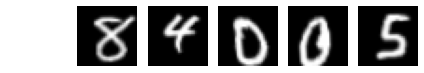

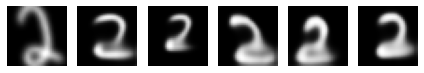

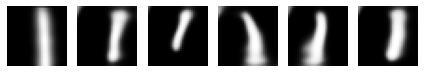

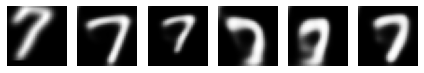

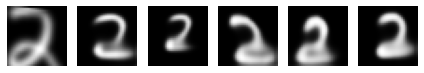

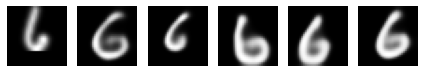

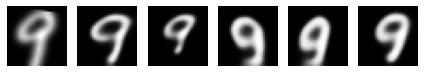

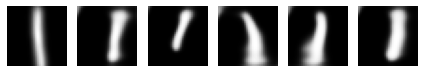

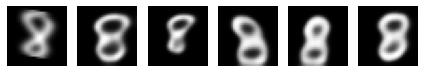

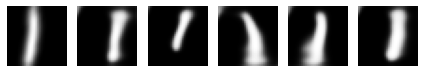

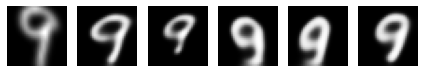

In [10]:
plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader)

In [ ]:
torch.save(model, "usps_to_mnist.pth")